Voici mon notebook sur le projet de test proposé par GoJob.
Le but est de regrouper en clusters les différents profils de worker.
Pour les tâches de NLP, j'utilise *SpaCy* et *re*, tandis que la partie clustering sera faites avec *sklearn* et *CoClust*.


In [1]:
!python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import spacy
import re
import seaborn as sns
nlp = spacy.load('fr_core_news_md')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data import

In [3]:
raw_dataset = pd.read_csv('/content/drive/My Drive/EMA/Stage/gojob/worker_profession.csv')
raw_dataset

,worker_id,list_professions
0,52754c03-3853-485b-8cc2-95c53684675c,Electricien |1;Cariste |107;Employé contact cl...
1,eeb85a73-0801-4206-bf9a-17dfa8bb3ae6,Préparateur de commandes |22;Ouvrier d'exécuti...
2,9dafeedd-8228-4543-abfd-a3ded0db696d,Assistant polyvalent / Secrétaire |13;Employé ...
3,15ce0846-1241-4d14-9ed8-2292efaa386d,Mécanicien |22;Peintre |10;Ouvrier d'exécution...
4,d40d5dce-3274-488b-a3f1-9947885fd94b,Ouvrier d'exécution polyvalent |0;Préparateur ...
...,...,...
28443,e87244a8-af6e-408b-914a-f72bce50ac95,Ouvrier d'exécution polyvalent |0;RH |0;Employ...
28444,1eb57f55-3700-4b51-aed6-77ac6c7d8162,Ouvrier d'exécution en milieu difficile |0;Ass...
28445,368cf021-c41f-4219-8ded-fe661b3592b3,Ouvrier d'exécution polyvalent |0;Assistant de...
28446,e54298d9-fa05-4a5e-8c0a-9521cc3e35df,Serveur et barman |5;Ouvrier d'exécution polyv...


In [4]:
# checking the type of the elements in list_professions
type(raw_dataset['list_professions'][0])

str

Il est nécessaire de travailler sur `list_professions` car on constate que les données ne sont pas exploitables en tant que telle.
Mon idée est de séparer dans deux colonnes différentes la liste des professions effectuées et les mois d'expériences pour chaque profession.

### Dealing with NaN values

In [4]:
# check for nan values
bool_series = pd.isnull(raw_dataset['list_professions'])  
raw_dataset[bool_series]

,worker_id,list_professions
15417,4da26848-b5df-4f6c-b702-fe58e5d06ab9,NaN
17955,dbfa02f5-9b76-46a7-b39d-563d61ed168e,NaN
21924,05d645f1-5406-49ce-8da7-604940125113,NaN
23431,d7afab4f-b53d-431a-81cc-4e21ba3fabf8,NaN


On constate qu'il y a 4 valeurs NA, soit un problème de collection de données soit que ces personnes n'ont jamais travaillé
.
2 solutions s'offrent à nous : 
* remplacer la valeur manquante par une catégorie pour ces 4 personnes (jamais travaillé, chomage, etc...)
* considérer que vu qu'il n'y as que 4 personnes concernées parmis les 28 000 du dataset, supprimer ces 4 profils. 

Je choisi de supprimer ces 4 profils, mais je suis conscient que dans la réalité, il faudrait trouver une autre solution pour les personnes avec ce type de profil. 

In [5]:
mod_dataset = raw_dataset.dropna()
print(len(raw_dataset), len(mod_dataset))
professions = mod_dataset['list_professions']
professions.head()

28448 28444


0    Electricien |1;Cariste |107;Employé contact cl...
1    Préparateur de commandes |22;Ouvrier d'exécuti...
2    Assistant polyvalent / Secrétaire |13;Employé ...
3    Mécanicien |22;Peintre |10;Ouvrier d'exécution...
4    Ouvrier d'exécution polyvalent |0;Préparateur ...
Name: list_professions, dtype: object

### Création d'un dataframe plus lisible
Utile pour conserver l'information de l'expérience d'une personne dans un job précis.

Il est nécessaire de travailler sur `list_professions` afin de pouvoir exploiter les données correctement.



In [0]:
professions_splitted = pd.DataFrame.copy(professions)

In [7]:
# splitting the professions so it's easier to access an element
 for idx in professions.index:
  professions_splitted[idx] = re.split(r"[;]", professions_splitted[idx])
  professions_splitted[idx] = ', '.join([str(elem) for elem in professions_splitted[idx]])
  professions_splitted[idx] = re.sub('[|]', '', professions_splitted[idx])
  professions_splitted[idx] = professions_splitted[idx].replace(' /', '')
  professions_splitted[idx] = re.sub('[-]', '_', professions_splitted[idx])

professions_splitted[173]

'Expert_comptable 0, Comptable général 11, Assistant comptable 0, Hotliner 13, Employé de bureau 0, Employé contact clientèle 0'

Création de deux foncions qui me seront utiles pour créer les nouvelles listes à utiliser.
*  **tokenization** sera utile pour tokeniser la chaine de charactères de professions d'un worker en supprimant les "stop word", ce qui permet de simplifier le vocabulaire. 
>J'ai pensé à lemmatiser les mots afin de diminuer le nombre de mots différents mais j'ai décidé que ce n'était pas forcément nécessaire.

* **experience_finder**: permet d'obtenir deux listes, une des professions effectuées par un worker et l'autre des expériences dans ces professions.

  

In [0]:
def tokenization(document):
  tokens = nlp(document)
  filtered_tokens = []
  for token in tokens:
    if not token.is_stop:
      filtered_tokens.append(token)
  return(filtered_tokens)


In [0]:
def experience_finder(tokens):
  experiences = []
  jobs = []
  job_string = ''
  for token in tokens:
    if token.is_digit:
      experiences.append(token)

    else:
      if not token.is_punct:
        job_string += token.text + ' '

      if token.is_punct:
        jobs.append(job_string)
        job_string = ''
        
  jobs.append(job_string)
  return(jobs, experiences)


On créer maintenant un dataframe avec ces deux nouvelles listes pour chaque worker, afin que les données soient plus lisibles.

In [0]:
professions_tokenized = pd.DataFrame.copy(professions_splitted)
experiences_splitted = []

for idx in professions_tokenized.index:
  tokenized = tokenization(professions_tokenized[idx])
  jobs, experience = experience_finder(tokenized)
  experiences_splitted.append(experience)
  professions_tokenized[idx] = jobs
d = {'nb_months': experiences_splitted}
experiences_df = pd.DataFrame(d)


In [0]:
experiences_df.index = professions_tokenized.index

In [17]:
workers = pd.DataFrame.copy(mod_dataset)
workers['list_professions'] = professions_tokenized
cleaned_workers = pd.concat([workers, experiences_df], axis=1)
cleaned_workers

,worker_id,list_professions,nb_months
0,52754c03-3853-485b-8cc2-95c53684675c,"[Electricien , Cariste , Employé contact clien...","[1, 107, 0, 1, 27, 0, 0, 0]"
1,eeb85a73-0801-4206-bf9a-17dfa8bb3ae6,"[Préparateur commandes , Ouvrier exécution pol...","[22, 0, 19, 0, 19, 0, 0]"
2,9dafeedd-8228-4543-abfd-a3ded0db696d,"[Assistant polyvalent Secrétaire , Employé con...","[13, 0, 0, 0, 0]"
3,15ce0846-1241-4d14-9ed8-2292efaa386d,"[Mécanicien , Peintre , Ouvrier exécution mili...","[22, 10, 0, 26, 5]"
4,d40d5dce-3274-488b-a3f1-9947885fd94b,"[Ouvrier exécution polyvalent , Préparateur co...","[0, 16, 0, 0, 0]"
...,...,...,...
28443,e87244a8-af6e-408b-914a-f72bce50ac95,"[Ouvrier exécution polyvalent , RH , Employé b...","[0, 0, 0, 17, 0, 0]"
28444,1eb57f55-3700-4b51-aed6-77ac6c7d8162,"[Ouvrier exécution milieu difficile , Assistan...","[0, 0, 0, 10, 0, 7, 15, 0]"
28445,368cf021-c41f-4219-8ded-fe661b3592b3,"[Ouvrier exécution polyvalent , Assistant dire...","[0, 0, 45, 0, 0, 0]"
28446,e54298d9-fa05-4a5e-8c0a-9521cc3e35df,"[Serveur barman , Ouvrier exécution polyvalent...","[5, 0, 0, 0, 0, 0]"


## Similarity between profiles

Il est temps de passer à l'analyse de texte.
Il est plus facile de travailler sur des chaines de caractères, je transforme donc `list_professions` en chaine de caractères.

In [18]:
workers_sim = cleaned_workers[['worker_id', 'list_professions']]
string_elt = ''
for idx in workers_sim.index:
  string_elt = ''
  for elt in workers_sim['list_professions'][idx]:
    string_elt += elt + ', '
  workers_sim['list_professions'][idx] = string_elt

workers_sim

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,worker_id,list_professions
0,52754c03-3853-485b-8cc2-95c53684675c,"Electricien , Cariste , Employé contact client..."
1,eeb85a73-0801-4206-bf9a-17dfa8bb3ae6,"Préparateur commandes , Ouvrier exécution poly..."
2,9dafeedd-8228-4543-abfd-a3ded0db696d,"Assistant polyvalent Secrétaire , Employé cont..."
3,15ce0846-1241-4d14-9ed8-2292efaa386d,"Mécanicien , Peintre , Ouvrier exécution milie..."
4,d40d5dce-3274-488b-a3f1-9947885fd94b,"Ouvrier exécution polyvalent , Préparateur com..."
...,...,...
28443,e87244a8-af6e-408b-914a-f72bce50ac95,"Ouvrier exécution polyvalent , RH , Employé bu..."
28444,1eb57f55-3700-4b51-aed6-77ac6c7d8162,"Ouvrier exécution milieu difficile , Assistant..."
28445,368cf021-c41f-4219-8ded-fe661b3592b3,"Ouvrier exécution polyvalent , Assistant direc..."
28446,e54298d9-fa05-4a5e-8c0a-9521cc3e35df,"Serveur barman , Ouvrier exécution polyvalent ..."


Maintenant que nous avons `list_professions` en chaine de caractères, la 1ère étape est de créer la sparse matrix tf-idf (term frequency-inverse document frequency) afin de connaitre l'importance de chaque mot dans cette colonne.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(workers_sim['list_professions']) #fit the vectorizer 

print(tfidf_matrix.shape)
print(tfidf_matrix)

(28444, 225)
  (0, 65)	0.1083697994440753
  (0, 139)	0.1083697994440753
  (0, 165)	0.0999436513349062
  (0, 91)	0.20332483818797742
  (0, 154)	0.20328892244672228
  (0, 30)	0.10821540234629921
  (0, 13)	0.5565771017394189
  (0, 50)	0.3193319433425262
  (0, 46)	0.10359708514472214
  (0, 56)	0.10378802635844099
  (0, 79)	0.20459355302173543
  (0, 33)	0.31651524407032977
  (0, 75)	0.5448390571753031
  (1, 37)	0.5047820804594162
  (1, 96)	0.5043987503206062
  (1, 148)	0.4270495299938275
  (1, 8)	0.26683912075369526
  (1, 49)	0.1857492491547749
  (1, 170)	0.1854525796198489
  (1, 65)	0.10167065276481312
  (1, 139)	0.10167065276481312
  (1, 165)	0.09376538780218562
  (1, 91)	0.19075581137842398
  (1, 154)	0.1907221158573778
  (1, 30)	0.10152580010478778
  :	:
  (28442, 66)	0.4976612200355432
  (28442, 24)	0.44541618650270487
  (28442, 190)	0.44541618650270487
  (28442, 17)	0.3247979286126008
  (28442, 65)	0.12392430555240415
  (28442, 139)	0.12392430555240415
  (28442, 165)	0.114288737725692

On a ainsi 225 mots reconnus dans les listes de professions : 

In [20]:
terms = tfidf_vectorizer.get_feature_names()
terms

['accompagnant',
 'accompagnateur',
 'accueil',
 'acheteur',
 'adjointe',
 'administration',
 'affaires',
 'affrètement',
 'agent',
 'aide',
 'ambulancier',
 'analyse',
 'animateur',
 'animation',
 'animatrice',
 'approvisionneur',
 'artistique',
 'assistant',
 'assitante',
 'atelier',
 'audit',
 'auditeur',
 'auxiliaire',
 'avocat',
 'barman',
 'bilingue',
 'biomédicale',
 'bloc',
 'bobinier',
 'brancardier',
 'bureau',
 'bâtiment',
 'caisse',
 'cariste',
 'carreleur',
 'carrière',
 'carrossier',
 'chambre',
 'chantier',
 'chargé',
 'charpentier',
 'chaudronnier',
 'chauffeur',
 'chef',
 'chercheur',
 'clients',
 'clientèle',
 'coffreur',
 'coiffeur',
 'commandes',
 'commercial',
 'commis',
 'comptable',
 'conditionnement',
 'conducteur',
 'conseil',
 'contact',
 'contrôleur',
 'coordinateur',
 'couvreur',
 'crèche',
 'cuisine',
 'câbleur',
 'dentaire',
 'dessinateur',
 'difficile',
 'direction',
 'directrice',
 'distributeur',
 'distribution',
 'défense',
 'déménageur',
 'développeur

On peut pousser l'analyse à déterminer la similarité entre les valeurs de `list_professions` de chaque worker.

In [0]:
#cosine similarity between documents 
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)


On obtient ainsi une matrice de similarité de dimensions (28444,28444), ce qui est très élevé et va demander beaucoup de mémoire de calcul.

On peut donc s'intéresser à la réduction de dimensions des features de `dist` afin de diminuer la dimension de cette matrice de similarité.

> 
**N'ayant pas le temps d'effectuer une réduction de dimension, j'aurai utilisé soit une méthode linénaire  comme le PCA : principal component analysis) ou une méthode non-linéaire (Manifold)**

## Clustering
Comme nous avons la matrice tfidf, nous pouvons essayer différents algorithmes de clustering.
Le premier test se base sur le basique *KMeans*.


### KMeans : single clustering

J'utilise la méthode du coude (*elbow method*) pour déterminer le nombre de clusters à utiliser.
>
Je n'ai cependant pas eu le temps d'exécuter la commande, j'ai quand même créé un modèle avec `n_clusters = 5`.

In [0]:
from sklearn.cluster import KMeans

# trouver le nombre de clusters optimaux
Sum_of_squared_distances = []
K = range(5,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [0]:
km_model = KMeans(n_clusters=5)
km_model = km_model.fit(tfidf_matrix)
clusters = km_model.labels_.tolist()

je crée un nouveau dataframe en ajoutant les clusters trouvés pour chaque worker. 

In [52]:
workers = {'worker_id': cleaned_workers['worker_id'], 'professions': cleaned_workers['list_professions'],'nb_months':cleaned_workers['nb_months'], 'cluster': clusters}

clusterized_workers = pd.DataFrame(workers, columns = ['worker_id', 'professions','nb_months', 'cluster'])
clusterized_workers

,worker_id,professions,nb_months,cluster
0,52754c03-3853-485b-8cc2-95c53684675c,"[Electricien , Cariste , Employé contact clien...","[1, 107, 0, 1, 27, 0, 0, 0]",1
1,eeb85a73-0801-4206-bf9a-17dfa8bb3ae6,"[Préparateur commandes , Ouvrier exécution pol...","[22, 0, 19, 0, 19, 0, 0]",1
2,9dafeedd-8228-4543-abfd-a3ded0db696d,"[Assistant polyvalent Secrétaire , Employé con...","[13, 0, 0, 0, 0]",4
3,15ce0846-1241-4d14-9ed8-2292efaa386d,"[Mécanicien , Peintre , Ouvrier exécution mili...","[22, 10, 0, 26, 5]",1
4,d40d5dce-3274-488b-a3f1-9947885fd94b,"[Ouvrier exécution polyvalent , Préparateur co...","[0, 16, 0, 0, 0]",2
...,...,...,...,...
28443,e87244a8-af6e-408b-914a-f72bce50ac95,"[Ouvrier exécution polyvalent , RH , Employé b...","[0, 0, 0, 17, 0, 0]",3
28444,1eb57f55-3700-4b51-aed6-77ac6c7d8162,"[Ouvrier exécution milieu difficile , Assistan...","[0, 0, 0, 10, 0, 7, 15, 0]",4
28445,368cf021-c41f-4219-8ded-fe661b3592b3,"[Ouvrier exécution polyvalent , Assistant dire...","[0, 0, 45, 0, 0, 0]",4
28446,e54298d9-fa05-4a5e-8c0a-9521cc3e35df,"[Serveur barman , Ouvrier exécution polyvalent...","[5, 0, 0, 0, 0, 0]",4


#### Visualisation

Par manque de temps, je n'ai pas pu mettre en place de visualisation pour ce clustering.
Cependant, j'aurai développé plusieurs graphes : 
- **scatterplot** de chaque clusters, avec en abscisse `worker_id` et en ordonnées `profession`. La couleur de chaque point serait le nombre de mois travaillé dans chaque professions. Comme il a une grande variance (entre 0 et 400 mois travaillés pour une expérience), on pourrait utiliser une échelle de couleur pour déterminer visuellement la différence d'expertise de chaque personne

- un **bar plot** des 5 termes les plus fréquents pour chaque cluster.

- potentiellement un **bubble plot** des workers avec en couleur leur cluster et en taille de point leur nombre de mois e'expériences cumulés.

### CoClustering
Après quelques recherches, j'ai découvert qu'il pouvait être intéressant de clusteriser les éléments sur les colonnes mais aussi sur les lignes afin d'obtenir de meilleurs groupements.
J'utilise un module dédié pour cela, appelé **CoClust** 

In [23]:
!pip install coclust

  Created wheel for coclust: filename=coclust-0.2.1-cp36-none-any.whl size=29872 sha256=ce8cc9f6a2c477497ee29fc0f071a1756e99ae47528caacb16ef83dc26116e83
  Stored in directory: /root/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


Afin de trouver quel est le nombre optimal de biclusters, j'utilise une méthode du module en mesurant la modularité de chaque modèle.


Computing coclust modularity for a range of cluster numbers =
 5 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 6 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 7 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 8 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 9 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 10 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 11 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 12 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 13 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 14 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 15 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 16 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 17 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 18 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 19 ...


/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


 All done !


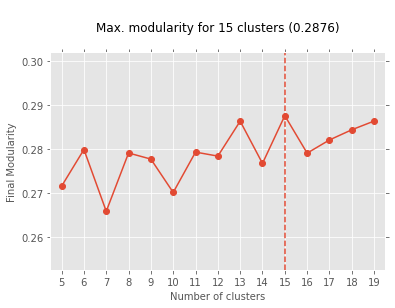

In [34]:
from coclust.coclustering import CoclustMod
from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities, 
                                   get_term_graph)
from coclust.evaluation.internal import best_modularity_partition
import seaborn as sns
# model = CoclustMod(n_clusters=5)
# model.fit(tfidf_matrix)

# print(model.modularity)
# predicted_row_labels = model.row_labels_
# predicted_column_labels = model.column_labels_


# get the best co-clustering over a range of cluster numbers
clusters_range = range(5, 20)
model, modularities = best_modularity_partition(tfidf_matrix, clusters_range, n_rand_init=1)


# plot the modularities over the range of cluster numbers
plot_max_modularities(modularities, range(5, 20))



Nous allons donc utiliser 15 bi-clusters

#### Visualisation

/usr/local/lib/python3.6/dist-packages/coclust/coclustering/coclust_mod.py:97: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


model modularity: 0.28157493104703846


/usr/local/lib/python3.6/dist-packages/coclust/visualization/__init__.py:228: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


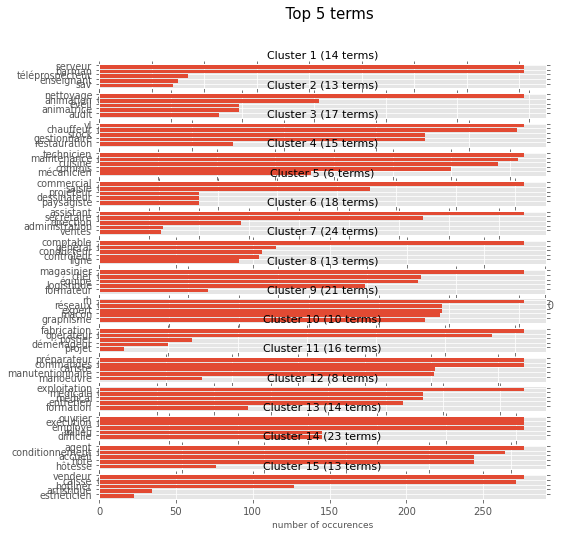

In [41]:
biclust_model = CoclustMod(n_clusters=15)
biclust_model.fit(tfidf_matrix)

print('model modularity:', biclust_model.modularity)

# plot des 5 termes les plus fréquents pour chaque cluster pour le modèle 

plot_cluster_top_terms(tfidf_matrix, terms, n_terms, biclust_model)



# Difficultés rencontrées

Je pense avoir manqué de temps afin d'exploiter et développer correctemment ce projet (notamment la visualisation des données), cependant j'ai eu quelques difficultés à comprendre comment fonctionnait le biclustering.
Je suis conscient que mon travail est loin d'être parfait mais j'espère qu'il aura tout de même permis de montrer mon potentiel.
